In [ ]:
# default_exp processing

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

# processing
> Processing the different stream of data to calculate responses of retinal cells

In [ ]:
#export
from functools import partial
import numpy as np
from sklearn.decomposition import PCA
from sklearn import cluster
import scipy.ndimage as ndimage
import scipy.signal as signal
import scipy as sp
from cmath import *
import itertools
import random

from theonerig.core import *
from theonerig.utils import *
from theonerig.modelling import *

# Spatial stimulus (checkerboard)

In [ ]:
#export
def eyetrack_stim_inten(stim_inten, eye_track, 
                        upsampling=2,
                        eye_calib=[[94 ,8], [ 18, 59]],
                        box_w=None, box_h=None, stim_axis="x"):
    """
    From stimulus data and eye tracking, returns a corrected and upsampled stimulus data.
    Calibration corresponds to the width and height of the stimulus screen, in 
    terms of pixels in the eye video: [[WIDTH_x, WIDTH_y], [HEIGHT_x, HEIGHT_y]]
    
    params:
        - stim_inten: Stimulus intensity matrix of shape (t, y, x), or (t, x) or (t, y) depending on stim_axis
        - eye_track: Eye tracking data of shape (t, x_pos, y_pos, ...)
        - upsampling: Factor for the upsampling (2 will multiply by 2 number of box in width and height)
        - eye_calib: Calibration matrix of shape (2,2)
        - box_w: Width of a block in pixel (40px in case of a 32 box in width of a checkerboard on a 1280px width)
        - box_h: Height of a block in pixel. Both box_x and box_h are calculated from a 1280x720 screen if None
        - stim_axis: Specify which direction to shift in case of stim shape different than (t, y, x)
        
    return:
        - Upsampled and shift corrected stimulus intensity
    """
    eye_x, eye_y = eye_track[:,0], eye_track[:,1]
    shape_y, shape_x = 1, 1
    if len(stim_inten.shape)==2:
        if stim_axis=="x":
            shape_x = stim_inten.shape[1]
        elif stim_axis=="y":
            shape_y = stim_inten.shape[1]
    elif len(stim_inten.shape)==3:
        shape_y = stim_inten.shape[1]
        shape_x = stim_inten.shape[2]
    if box_w is None:
        box_w = 1280//shape_x
    if box_h is None:
        box_h = 720//shape_y

    if shape_y>1 and shape_x>1:
        box_w, box_h = int(box_w/upsampling), int(box_h/upsampling)
    elif shape_x > 1:
        box_w, box_h = int(box_w/upsampling), box_h
    elif shape_y > 1:
        box_w, box_h = box_w                , int(box_h/upsampling)

    eye_transfo_f = _eye_to_stim_f(eye_calib=eye_calib, 
                                  box_width=box_w,
                                  box_height=box_h)
    
    if shape_y>1 and shape_x>1:
        stim_inten = stim_inten.repeat(upsampling,axis=1).repeat(upsampling,axis=2)
    else:
        stim_inten = stim_inten.repeat(upsampling,axis=1)
        
    xpos_avg = np.mean(eye_x)
    ypos_avg = np.mean(eye_y)
    mean_stim_inten = int((np.max(stim_inten)+np.min(stim_inten))/2)
    #After getting the shift of the matrix to apply, we roll the matrix instead of extending it to the shifts
    #This seems strange, but from the cell point of view, that is potentially looking at no stimulus,
    # the response it gives are uncorrelated with the stimulus, and so shouldn't impact further analysis
    # Advantage is that it keeps the data small enough, without loosing regions of the stimulus.
    for i in range(len(stim_inten)):
        x_eyeShift = eye_x[i]-xpos_avg
        y_eyeShift = eye_y[i]-ypos_avg
        
        stim_shift_x, stim_shift_y = eye_transfo_f(x_eyeShift=x_eyeShift,
                                                   y_eyeShift=y_eyeShift) 
        if shape_y>1 and shape_x>1:
            rolled_stim = np.roll(stim_inten[i],stim_shift_y,axis=0)
            rolled_stim = np.roll(rolled_stim  ,stim_shift_x,axis=1)
        else:
            if stim_axis=="x":
                rolled_stim = np.roll(stim_inten[i],stim_shift_x,axis=0)
            else:
                rolled_stim = np.roll(stim_inten[i],stim_shift_y,axis=0)
        stim_inten[i] = rolled_stim
        
    return stim_inten

def saccade_distances(eye_track):
    """
    Create a mask for the eye position timeserie that indicate how far was the last saccade.
    The eye positions need to be smoothed with smooth_eye_position.
    
    params:
        - eye_track: Eye tracking data of shape (t, x_pos, y_pos, ...)
        
    return:
        - Distance to last saccade array
    """
    
    x_pos, y_pos = eye_track[:,0], eye_track[:,1]
    saccade_pos = np.where((x_pos[1:] != x_pos[:-1]) & (y_pos[1:] != y_pos[:-1]))[0] + 1
    
    len_chunks = [saccade_pos[0]]+list(saccade_pos[1:]-saccade_pos[:-1])
    len_chunks.append(len(x_pos) - saccade_pos[-1])
    
    saccade_mask = []
    for len_chunk in len_chunks:
        saccade_mask.extend(list(range(len_chunk)))
    
    return np.array(saccade_mask)

def smooth_eye_position(eye_track, threshold=2):
    """
    Smooth the eye positions. Uses clustering of eye position epochs to smooth.
    Clustering is made with sklearn.cluster.dbscan.
    
    params:
        - eye_track: Eye tracking data of shape (t, x_pos, y_pos, ...)
        - threshold: Distance threshold in the position clustering
        
    return:
        - Distance to last saccade array
    """
    x_pos, y_pos = eye_position[:,0], eye_position[:,1]

    X = np.stack((x_pos,y_pos, np.linspace(0, len(x_pos)/2, len(x_pos)))).T
    clusters = cluster.dbscan(X, eps=threshold, min_samples=3, metric='minkowski', p=2)

    move_events = np.where(clusters[1][1:] > clusters[1][:-1])[0] + 1
    
    len_chunks = [move_events[0]]+list(move_events[1:]-move_events[:-1])
    len_chunks.append(len(x_pos) - move_events[-1])

    eye_x_positions = np.split(x_pos, move_events)
    eye_y_positions = np.split(y_pos, move_events)

    mean_x_pos = np.array(list(map(np.mean, eye_x_positions)))
    mean_y_pos = np.array(list(map(np.mean, eye_y_positions)))
    
    x_pos_smooth = np.concatenate([[x_pos]*len_chunk for x_pos,len_chunk in zip(mean_x_pos, len_chunks)])
    y_pos_smooth = np.concatenate([[y_pos]*len_chunk for y_pos,len_chunk in zip(mean_y_pos, len_chunks)])
    
    return np.stack((x_pos_smooth, y_pos_smooth)).T

def _eye_to_stim_f(eye_calib, box_width, box_height):
    """
    Initialise stimulus shift function parameters and returns a partial function.
    
    params:
        - eye_calib: Calibration matrix of shape (2,2)
        - box_width: Width of the elementary block in pixel
        - box_height: Width of the elementary block in pixel
        
    return:
        - Partial function to obtain stimulus shift from eye positions
    """
    eye_to_stim     = np.linalg.inv(eye_calib)
    box_dim         = np.array([1280/(box_width), 720/(box_height)])
    return partial(_linear_transform, box_dim=box_dim, transfo_matrix=eye_to_stim)
    
def _linear_transform(box_dim, transfo_matrix, x_eyeShift, y_eyeShift):
    """
    Computes the shift of the stimulus from eye position shifts.
    
    params:
        - box_dim: Size in pixel of the box [width, height]
        - transfo_matrix: Inverse matrix of the calibration matrix described in eyetrack_stim_inten
        - x_eyeShift: Eye shift in x
        - y_eyeShift: Eye shift in y
        
    return:
        - Stimulus shift tuple (delta_x, delta_y)
    """
    transform_coord = np.dot(transfo_matrix, np.array([x_eyeShift, y_eyeShift]).T)
    stim_vec        = np.round(transform_coord * box_dim).astype(int)
    return stim_vec[0], -stim_vec[1]

In [ ]:
#export
def process_sta_batch(stim_inten, spike_counts, Hw=30, Fw=2, return_pval=False, normalisation="abs"):
    """
    Computes the STA and associated pvalues in parallel for a batch of cells.
    
    params:
        - stim_inten: stimulus intensity matrix of shape (t, ...)
        - spike_counts: cells activity matrix of shape (t, n_cell)
        - Hw: Lenght in frames of the history window, including the 0 timepoint
        - Fw: Lenght in frames of the forward window
        - return_pval: Flag to signal whether or not to return the pvalues
        - normalisation: Normalization applied to the STA. One of ["abs", "L2", None]
        
    return:
        - stas of shape (n_cell, Hw+Fw, ...)
        - stas and pvalues if return_pval=True, both of shape (n_cell, Hw+Fw, ...)
    """
    assert normalisation in ["abs", "L2", None], "normalisation must be one of ['abs', 'L2', None]"
    #Preparing the stimulus
    orig_shape = stim_inten.shape
    stim_inten = stim_inten_norm(stim_inten)
    sum_spikes = np.sum(spike_counts, axis=0)
    len_stim = len(stim_inten)
    
    #We just have to calculate one STA over the whole record
    stim_inten   = np.reshape(stim_inten, (len(stim_inten),-1))
    stim_inten   = np.transpose(stim_inten)
    allCells_sta = staEst_fromBins(stim_inten, spike_counts, Hw, Fw=Fw)

    if len(orig_shape)==3:
        allCells_sta = allCells_sta.reshape((len(allCells_sta),Hw+Fw, orig_shape[-2], orig_shape[-1]))
    elif len(orig_shape)==2:
        allCells_sta = allCells_sta.reshape((len(allCells_sta),Hw+Fw,-1))
    else:
        allCells_sta = allCells_sta.reshape((len(allCells_sta),Hw+Fw))
        
    if allCells_sta.shape[0]==1: #Only one cell, but we need to keep the axis
        allCells_sta = np.squeeze(allCells_sta)
        allCells_sta = np.expand_dims(allCells_sta, axis=0)
    else:
        allCells_sta = np.squeeze(allCells_sta)
    
    if return_pval:
        p_values = np.empty(allCells_sta.shape)
    for k, cell_sta in enumerate(allCells_sta): #Easy way to do normalization for each cell that works for all possible shapes
        if return_pval:
            z_scores    = cell_sta/ np.sqrt(1/sum_spikes[k]) #Standard score is calculated as (x-mean)/std
            p_values[k] = sp.stats.norm.sf(abs(z_scores))*2
            
        if normalisation is None:
            continue
        elif normalisation=="abs":
            allCells_sta[k] = np.nan_to_num(cell_sta/np.max(np.abs(cell_sta)))
        elif normalisation=="L2":
            allCells_sta[k] = np.nan_to_num(cell_sta/np.sqrt(np.sum(np.power(cell_sta, 2))))
        
    if return_pval:
        return allCells_sta, p_values
    else:
        return allCells_sta
    
def staEst_fromBins(stim, spike_counts, Hw, Fw=0):
    """
    Matrix mutliplication to compute the STA. Use the wrapper process_sta_batch to avoid bugs.
    
    params:
        - stim_inten: stimulus intensity matrix of shape (flattened_frame, t)
        - spike_counts: cells activity matrix of shape (t, n_cell)
        - Hw: Lenght in frames of the history window, including the 0 timepoint
        - Fw: Lenght in frames of the forward window
        
    return:
        - STA of shape (n_cell, Hw+Fw, flattened_frame)
    """
    spike_counts[:Hw] = 0
    
    spike_counts = np.nan_to_num(spike_counts / np.sum(spike_counts,axis=0))
    spike_counts = spike_counts - np.mean(spike_counts, axis=0) #Center to 0 the spike counts to include "inhibitory" stimulus
    sta = np.zeros((Hw+Fw, stim.shape[0], spike_counts.shape[-1]))
    for i in range(Hw): #Does the dot product of cell activity and frame intensity matrix
        sta[(Hw-1-i),:,:] = np.dot(stim, spike_counts)
        spike_counts      = np.roll(spike_counts, -1, axis=0) #And shift the activity to compute the next frame
    spike_counts = np.roll(spike_counts, Hw, axis=0)
    if Fw != 0:
        spike_counts[-Fw:] = 0
    for i in range(Fw): #Same thing for Fw
        spike_counts  = np.roll(spike_counts, 1, axis=0)
        sta[Hw+i,:,:] = np.dot(stim, spike_counts)
    spike_counts = np.roll(spike_counts, -Fw, axis=0)
    return np.transpose(sta, (2,0,1))

def process_sta_batch_large(stim_inten, spike_counts, Hw=30, Fw=2, return_pval=False, normalisation="abs", bs=1000):
    """
    Computes the STA and associated pvalues in parallel for a batch of cells, for a large stimulus.
    
    params:
        - stim_inten: stimulus intensity matrix of shape (t, ...)
        - spike_counts: cells activity matrix of shape (t, n_cell)
        - Hw: Lenght in frames of the history window, including the 0 timepoint
        - Fw: Lenght in frames of the forward window
        - return_pval: Flag to signal whether or not to return the pvalues
        - normalisation: Normalization applied to the STA. One of ["abs", "L2", None]
        - bs: batch size to compute partial STA
        
    return:
        - stas of shape (n_cell, Hw+Fw, ...)
        - stas and pvalues if return_pval=True, both of shape (n_cell, Hw+Fw, ...)
    """
    orig_shape = stim_inten.shape
    n_spatial_dim = orig_shape[1]*orig_shape[2]
    
    sum_spikes = np.sum(spike_counts, axis=0)
    len_stim = len(stim_inten)
    allCells_sta = np.zeros((n_spatial_dim, spike_counts.shape[1], Hw+Fw))
    stim_inten = stim_inten.reshape((len_stim,-1))
    print("Computing the STA part by part:")
    for i, batch_pos in enumerate(range(0, n_spatial_dim, bs)):
        print(str(round(100*batch_pos/n_spatial_dim,2))+"%      ", end="\n", flush=True)
        #Computing STA on partial portions of the screen sequentially
        stim_part = stim_inten_norm(stim_inten[:, batch_pos:batch_pos+bs]).T
        sub_sta = staEst_fromBins(stim_part, spike_counts, Hw, Fw=Fw)
        allCells_sta[batch_pos:batch_pos+bs] = np.transpose(sub_sta, (2,0,1))#(ncell,Hw,stim_len) to (stim_len,ncell,Hw)
    allCells_sta = np.transpose(allCells_sta, (1,2,0))
    print("100%      ")
    
    if len(orig_shape)==3:
        allCells_sta = allCells_sta.reshape((len(allCells_sta),Hw+Fw, orig_shape[-2], orig_shape[-1]))
    elif len(orig_shape)==2:
        allCells_sta = allCells_sta.reshape((len(allCells_sta),Hw+Fw,-1))
    else:
        allCells_sta = allCells_sta.reshape((len(allCells_sta),Hw+Fw))

    if allCells_sta.shape[0]==1: #Only one cell, but we need to keep the axis
        allCells_sta = np.squeeze(allCells_sta)
        allCells_sta = np.expand_dims(allCells_sta, axis=0)
    else:
        allCells_sta = np.squeeze(allCells_sta)

    if return_pval:
        p_values = np.empty(allCells_sta.shape)
    for k, cell_sta in enumerate(allCells_sta): #Easy way to do normalization for each cell that works for all possible shapes
        if return_pval:
            z_scores    = cell_sta/ np.sqrt(1/sum_spikes[k]) #Standard score is calculated as (x-mean)/std
            p_values[k] = sp.stats.norm.sf(abs(z_scores))*2

        if normalisation is None:
            continue
        elif normalisation=="abs":
            allCells_sta[k] = np.nan_to_num(cell_sta/np.max(np.abs(cell_sta)))
        elif normalisation=="L2":
            allCells_sta[k] = np.nan_to_num(cell_sta/np.sqrt(np.sum(np.power(cell_sta, 2))))

    if return_pval:
        return allCells_sta, p_values
    else:
        return allCells_sta

In [ ]:
#export
def cross_correlation(spike_counts, tail_len=100):
    """
    From calculate the cross correlation of the cells over a time window.
    
    params:
        - spike_counts of shape (t, n_cell)
        - tail_len: time correlation window size 
        
    return:
        - cross correlation between the cells
    """
    n_dpoints, n_cell = spike_counts.shape
    corr_arr = np.zeros((n_cell,n_cell,tail_len+1))
    spike_counts = (spike_counts / np.max(spike_counts, axis=0)) #Independant normalization of the cells
    spike_counts_edged = np.concatenate((np.zeros((tail_len,n_cell)), 
                    spike_counts, 
                    np.zeros((tail_len,n_cell)))) #Creating an array with 0 tails on both side to use the valid mode
                                                  # of numpy.correlate
    for i in range(n_cell):
        for j in range(i, n_cell):
            corr_arr[i,j] = np.correlate(spike_counts_edged[:,i],
                                         spike_counts[:,j], 
                                         mode="valid")
            corr_arr[j,i] = corr_arr[i,j]
    return corr_arr/n_dpoints

In [ ]:
#export
def corrcoef(spike_counts):
    """
    Computes correlation coefficient between the cells
    
    params:
        - spike_counts: Cells activity of shape (t, n_cell)
        
    return:
        - Correlation matrix
    """
    return np.corrcoef(spike_counts.T)

def flatten_corrcoef(corrcoef_matrix):
    """
    Retrieves a one dimensional array of the cells correlations
    
    params:
        - corrcoef_matrix: Correlation matrix from `corrcoef`
    
    return:
        - flattened correlation matrix"""
    shp = corrcoef_matrix.shape
    return np.array([corrcoef_matrix[i,j] for i in range(shp[0]) for j in range(i+1, shp[0])])

In [ ]:
#export
def stimulus_ensemble(stim_inten, Hw=30, x=0, y=0, w=None, h=None):
    """
    Generate the stimulus ensemble used to compute the nonlinearity
    
    params:
        - stim_inten: stimulus intensity matrix of shape (t, ...)
        - Hw: Lenght in frames of the history window, including the 0 timepoint
        - x: Left position of the window where to get the ensemble from
        - y: Up position of the window where to get the ensemble from
        - w: Width of the window where to get the ensemble from
        - h: Height of the window where to get the ensemble from
        
    return:
        - Flatten stimulus ensemble of size (len(stim_inten)-Hw, w*h)
    """
    stim_inten = stim_inten_norm(stim_inten)
    if w is None:
        w = stim_inten.shape[2]
    if h is None:
        h = stim_inten.shape[1]
    xmin, xmax = max(0,x-w), min(stim_inten.shape[2], x+w+1)
    ymin, ymax = max(0,y-h), min(stim_inten.shape[1], y+h+1)
    dtype = stim_inten.dtype
    if np.all(np.in1d(stim_inten, [-1,0,1])):
        dtype = "int8"
    stim_ensmbl = np.zeros((len(stim_inten)-Hw, (xmax-xmin)*(ymax-ymin)*Hw), dtype=dtype)
    for i in range(Hw, len(stim_inten)):
        flat_stim         = np.ndarray.flatten(stim_inten[i-Hw:i,
                                                          ymin:ymax,
                                                          xmin:xmax])
        stim_ensmbl[i-Hw] = flat_stim
    return stim_ensmbl

def process_nonlinearity(stim_ensemble, spike_counts):
    """
    Computes the nonlinearity of a single cell
    
    params:
        - stim_ensemble: stimulus ensemble obtained with `stimulus_ensemble`
        - spike_counts: cells activity (without the initial Hw, same as the stimulus ensemble)
        
    return:
        - nonlinearity of the cell.
    """
    assert len(stim_ensemble)==len(spike_counts)
    stim_ensmbl_mean  = np.mean(stim_ensemble,axis=0)#np.mean(spike_triggering_stimuli,axis=0)
    spike_ensmbl_mean = np.average(stim_ensemble, axis=0, weights=spike_counts)
    middle_vec = np.mean(np.stack((stim_ensmbl_mean, spike_ensmbl_mean)), axis=0)

    pca = PCA(n_components=2)
    fit = pca.fit(np.stack((stim_ensmbl_mean,
                            spike_ensmbl_mean,
                            middle_vec)))
    stim_ensemble_tranfo = fit.transform(stim_ensemble)

    if np.max(spike_counts)<1:#We have probabilities, not spike counts. Need to make it integers
        mask        = np.where(spike_counts > 0)[0]
        nonzero_min = np.min(spike_counts[mask])
        discretized = spike_counts/nonzero_min
        spike_bins  = ((10*discretized)/(np.max(discretized))).astype(int)
        
    spike_ensembl = stim_ensemble_tranfo[np.where(spike_counts)[0]]
    
    xaxis      = np.linspace(np.min(stim_ensemble_tranfo),np.max(stim_ensemble_tranfo),101)
    hist_all   = np.histogram(stim_ensemble_tranfo, bins=xaxis)[0]
    hist_trigg = np.histogram(spike_ensembl, bins=xaxis)[0]

    nonlin = hist_trigg/hist_all

    nonlin = fill_nan(nonlin)
    return nonlin
        

In [ ]:
#export
def activity_histogram(spike_counts):
    """
    Retrieve an histogram of the individual cells activity.
    
    params:
        - spike_counts: cells activity matrix of shape (t, n_cell)
        
    return:
        - Cells activity histogram
    """
    flat_spikes = spike_counts.reshape(-1)
    flat_cell = np.array([[i]*spike_counts.shape[0] for i in range(spike_counts.shape[1])]).reshape(-1)
    hist = np.histogram2d(flat_spikes, flat_cell, bins=[100,spike_counts.shape[1]])[0] / spike_counts.shape[0]
    return hist

In [ ]:
#export
def cross_distances(masks):
    """
    Computes cross distances from the center of mass of a list of mask. 
    
    params:
        - masks: cells mask of shape (n_mask, y, x)
        
    return:
        - cross distances matrix
    """
    center_mass = np.array([ndimage.measurements.center_of_mass(mask) for mask in masks])
    cross_distances = np.zeros((len(masks),len(masks)))
    for i in range(len(masks)):
        for j in range(i,len(masks)):
            cross_distances[i,j] = np.linalg.norm(center_mass[i]-center_mass[j])
            cross_distances[j,i] = cross_distances[i,j]
    return cross_distances

def cross_distances_sta(fits, sta_shape, f):
    """
    Computes cross distances between STAs 
    
    params:
        - fits: fits of STA to compare
        - sta_shape: shape of the STA
        - f: function used to compute the stas from the fits parameters
        
    return:
        - cross distances matrix
    """
    sta_masks = np.array([img_2d_fit(sta_shape, fit, f) for fit in fits])
    for i,sta_mask in enumerate(sta_masks):
        if abs(np.min(sta_mask)) > np.max(sta_mask):
            sta_masks[i] = sta_mask < -.5
        else:
            sta_masks[i] = sta_mask > .5
    return cross_distances(sta_masks)

def paired_distances(masks_1, masks_2):
    """
    Compute the distance between two masks
    
    params:
        - masks_1: Mask of the first cell
        - masks_2: Mask of the second cell
        
    return:
        - distance between the two masks
    """
    center_mass_1 = np.array([ndimage.measurements.center_of_mass(mask) for mask in masks_1])
    center_mass_2 = np.array([ndimage.measurements.center_of_mass(mask) for mask in masks_2])
    paired_distances = np.zeros(len(masks_1))
    for i, (center_1, center_2) in enumerate(zip(masks_1, masks_2)):
        paired_distances[i] = np.linalg.norm(center_1-center_2)
    return paired_distances

def paired_distances_sta(sta_fits_1, sta_fits_2, sta_shape, f):
    """
    Compute the distance between two STAs.
    
    params:
        - sta_fits_1: fits of STA of the first cell
        - sta_fits_2: fits of STA of the second cell
        - sta_shape: shape of the STA
        - f: function used to compute the stas from the fits parameters
        
    return:
        - distance between the two STAs
    """
    sta_masks_1 = np.array([img_2d_fit(sta_shape, fit, f) for fit in sta_fits_1])
    for i,sta_mask in enumerate(sta_masks_1):
        if abs(np.min(sta_mask)) > np.max(sta_mask):
            sta_masks_1[i] = sta_mask < -.5
        else:
            sta_masks_1[i] = sta_mask > .5
    sta_masks_2 = np.array([img_2d_fit(sta_shape, fit, f) for fit in sta_fits_2])
    for i,sta_mask in enumerate(sta_masks_2):
        if abs(np.min(sta_mask)) > np.max(sta_mask):
            sta_masks_2[i] = sta_mask < -.5
        else:
            sta_masks_2[i] = sta_mask > .5
    return paired_distances(sta_masks_1, sta_masks_2)

# Direction and orientation selectivity with imaginary numbers

We have 8 angles

In [ ]:
n_angle = 8
x = np.linspace(0, (n_angle-1)/4*np.pi, num=n_angle)
print(x)

[0.         0.78539816 1.57079633 2.35619449 3.14159265 3.92699082
 4.71238898 5.49778714]


Exponentiating those and multiplying with 0+1i will wind up the angles around the origin in imag number space

In [ ]:
vectors = np.exp(x*1j)
print(vectors)

[ 1.00000000e+00+0.00000000e+00j  7.07106781e-01+7.07106781e-01j
  6.12323400e-17+1.00000000e+00j -7.07106781e-01+7.07106781e-01j
 -1.00000000e+00+1.22464680e-16j -7.07106781e-01-7.07106781e-01j
 -1.83697020e-16-1.00000000e+00j  7.07106781e-01-7.07106781e-01j]


And so multiplying by two before exponentiation double the angle of the arrow. It gives to originally opposite vectors the same direction -> good to calculate orientation selectivity

Text(0.5, 1.0, 'OS vectors')

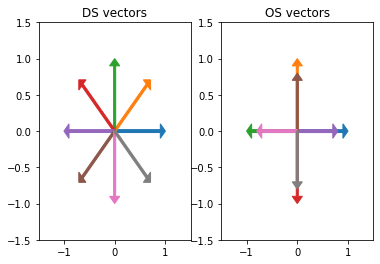

In [ ]:
import matplotlib.pyplot as plt
colors = plt.rcParams["axes.prop_cycle"].by_key()['color']

fig, axs = plt.subplots(1,2)
vectors = np.exp(x*1j)
for dx,dy, c in zip (vectors.real, vectors.imag, colors):
    axs[0].arrow(0, 0, dx, dy, head_width=0.2, head_length=0.1,length_includes_head=True, color=c, width=.04)
axs[0].set_xlim(-1.5,1.5)
axs[0].set_ylim(-1.5,1.5)
axs[0].set_title("DS vectors")

vectors = np.exp(x*1j*2)
for i,(dx,dy,c) in enumerate(zip(vectors.real, vectors.imag, colors)):
    if i>=4:
        dx = dx*0.8
        dy = dy*0.8
    axs[1].arrow(0, 0, dx, dy, head_width=0.2, head_length=0.1, length_includes_head=True, color=c, width=.04)
axs[1].set_xlim(-1.5,1.5)
axs[1].set_ylim(-1.5,1.5)
axs[1].set_title("OS vectors")

In [ ]:
#export
def direction_selectivity(grouped_spikes_d, n_bootstrap=1000):
    """
    Compute the direction selectivity index of cells in the given dict containing for each condition as
    the keys, an array of shape (n_angle, n_repeat, trial_len, n_cell). Such dictionnary can be obtained
    by using `utils.group_direction_response`.
    
    params:
        - grouped_spikes_d: Results of the group_direction_response of shape (n_angle, n_repeat, t, n_cell)
        - n_bootstrap: Number of bootstrap iteration to calculate the p-value
    
    return:
        - A dictionnary with a key for each condition retrieving a tuple containing list of the cells
        (spike sum, direction pref, DS idx, orientation pref, OS idx, pval DS, pval OS)
    """
    
    res_d = {}
    for cond, sp_count in grouped_spikes_d.items():
        n_angle = sp_count.shape[0]
        sum_rep_spike = np.sum(sp_count, axis=(1,2)).T

        x         = np.linspace(0, (n_angle-1)/4*np.pi, num=n_angle)

        #Direction selectivity
        vect_dir  = np.exp(x*1j)#np.array([np.cos(x) + np.sin(x)*1j])
        dir_pref  = np.nan_to_num((vect_dir * sum_rep_spike).sum(axis=1) / sum_rep_spike.sum(axis=1))
        ds_idx    = abs(dir_pref)

        #Orientation selectivity
        vect_ori  = np.exp(x*1j*2)#np.concatenate((vect_dir[:,:n_angle//2], vect_dir[:,:n_angle//2]), axis=1)
        ori_pref  = np.nan_to_num((vect_ori * sum_rep_spike).sum(axis=1) / sum_rep_spike.sum(axis=1))
        ori_idx   = abs(ori_pref)

        #Generating direction and orientation index from shuffled trials
        axtup_l = list(itertools.product(range(sp_count.shape[0]), range(sp_count.shape[1])))
        random.seed(1)
        axtup_l_shuffled = axtup_l.copy()
        rand_ori_idx_l = np.empty((n_bootstrap, sp_count.shape[3]))
        rand_dir_idx_l = np.empty((n_bootstrap, sp_count.shape[3]))
        for i in range(n_bootstrap):
            random.shuffle(axtup_l_shuffled)
            shuffled_sp_count = np.empty(sp_count.shape)
            for axtup, axtup_shuff in zip(axtup_l, axtup_l_shuffled):
                shuffled_sp_count[axtup] = sp_count[axtup_shuff]
            rand_sum_rep_spike      = np.sum(shuffled_sp_count, axis=(1,2)).T
            rand_dir_pref     = np.nan_to_num((vect_dir * rand_sum_rep_spike).sum(axis=1) / rand_sum_rep_spike.sum(axis=1))
            rand_dir_idx_l[i] = abs(rand_dir_pref)

            rand_ori_pref     = np.nan_to_num((vect_ori * rand_sum_rep_spike).sum(axis=1) / rand_sum_rep_spike.sum(axis=1))
            rand_ori_idx_l[i] = abs(rand_ori_pref)

        #Same calculation of pval as in Baden et al 2016
        p_val_dir = 1 - (np.sum(rand_dir_idx_l<ds_idx, axis=0)/n_bootstrap)
        p_val_ori = 1 - (np.sum(rand_ori_idx_l<ori_idx, axis=0)/n_bootstrap)

        #Finally we have to transform the orientation selectivity vectors to put them back in their
        # original orientation, by divinding the phase of the vector by two
        tau = np.pi*2
        polar_ori_pref = np.array(list((map(polar, ori_pref))))
        polar_ori_pref[:,1] = ((polar_ori_pref[:,1]+tau)%tau)/2 #Convert to positive radian angle and divide by two
        ori_pref = np.array([rect(pol[0], pol[1]) for pol in polar_ori_pref])

        res_d[cond] = (sum_rep_spike, dir_pref, ds_idx, ori_pref, ori_idx, p_val_dir, p_val_ori)
        
    return res_d

In [ ]:
#export
def wave_direction_selectivity(wave_array, spike_counts, moving_distance_th=1, looming_distance_th=.3, n_bootstrap=1000):
    """
    Computes the direction, orientation and looming/shrinking indexes of the cells in response to the wave stimulus (in LED dome).
    
    params:
        - wave_array: The indexes of the waves from the record master.
        - spike_counts: The cells response to the waves from the record master.
        - moving_distance_th: Distance threshold in radians above which a stimulus can be considered for the OS and DS.
        - looming_distance_th: Distance threshold in radians bellow which a stimulus can be considered for the looming/shrinking response
        - n_bootstrap: Number of repetition in the bootstraping method to compute the pvalues
        
    return:
        - A tuple containing lists of the cells response, in order:
            * summed_responses: Summed response of a cell to each wave condition
            * dir_pref_l: Direction preference vector
            * dir_idx_l : Direction indexes
            * dir_pval_l: Direction p_values
            * ori_pref_l: Orientation preference vector
            * ori_idx_l : Orientation indexes
            * ori_pval_l: Orientation p_values
            * loom_idx_l : Looming indexes 
            * loom_pval_l: Looming p_values
            * stas_position_l: Position (theta, phi) of the cells receptive fields with the water stimulus
            * waves_position_l: Relative positions of the waves to the cells STA.
    """
    tau = np.pi*2
    
    indexes, order = np.unique(wave_array, return_index=True)
    epoch_sequence = indexes[1:][np.argsort(order[1:])]
    wave_inten     = build_wave_stimulus_array(epoch_sequence)
    stas_wave      = process_sta_batch(wave_inten, spike_counts, Hw=1, Fw=0, return_pval=False)
    #Hw of 1 because there is a high temporal correlation in the stimulus, so that's enough to find the RF
    
    summed_responses = np.zeros((100, spike_counts.shape[1]))
    
    for i in indexes[1:]: #Iterate from 0 to n_wave-1
        where = np.where(wave_array==i)[0]
        summed_responses[i,:] = np.sum(spike_counts[where,:], axis=0)
      
    dome_positions = get_dome_positions(mode="spherical")
    
    ori_pref_l, dir_pref_l              = [], []
    ori_idx_l, dir_idx_l, loom_idx_l    = [], [], []
    ori_pval_l, dir_pval_l, loom_pval_l = [], [], []
    stas_position_l, waves_position_l   = [], []
    
    for sta, cell_responses  in zip(stas_wave, summed_responses.T):
        maxidx_sta     = np.argmax(np.abs(sta))
        theta_led      = dome_positions[maxidx_sta//237,maxidx_sta%237,1]
        phi_led        = dome_positions[maxidx_sta//237,maxidx_sta%237,2]
        relative_waves = get_waves_relative_position((theta_led, phi_led), mode="spherical")
        
        stas_position_l.append((theta_led, phi_led))
        waves_position_l.append(relative_waves)
    
        waves_distance = relative_waves[:,1]
        waves_angle    = (relative_waves[:,2]+tau)%(tau) #Set the angle in the (0,2pi) range

        looming_mask   = (waves_distance<looming_distance_th)
        shrink_mask    = (waves_distance>np.pi-looming_distance_th)
        waves_mask     = (waves_distance>moving_distance_th) & (waves_distance<np.pi-moving_distance_th)
        
        vectors_dir  = np.exp(waves_angle*1j)  #Create vectors using imaginary numbers
        vectors_ori  = np.exp(waves_angle*1j*2)#x2 gather the vectors with opposite directions
        dir_pref     = np.nan_to_num((vectors_dir[waves_mask] * cell_responses[waves_mask]).sum() / cell_responses[waves_mask].sum())
        ori_pref     = np.nan_to_num((vectors_ori[waves_mask] * cell_responses[waves_mask]).sum() / cell_responses[waves_mask].sum())
        ds_idx       = abs(dir_pref)
        os_idx       = abs(ori_pref)
        
        looming_response   = (cell_responses[looming_mask]).sum()
        shrinking_response = (cell_responses[shrink_mask]).sum()
        looming_idx        = (looming_response-shrinking_response)/(looming_response+shrinking_response)
        
        ori_pref_l.append(ori_pref); dir_pref_l.append(dir_pref)
        ori_idx_l.append(os_idx); dir_idx_l.append(ds_idx)
        loom_idx_l.append(looming_idx)
        
        np.random.seed(1)
        rand_ori_idx_l  = np.empty(n_bootstrap)
        rand_dir_idx_l  = np.empty(n_bootstrap)
        rand_loom_idx_l = np.empty(n_bootstrap)
        for i in range(n_bootstrap):
            shuffled_response = cell_responses.copy()
            np.random.shuffle(shuffled_response)
            
            rand_dir_pref     = np.nan_to_num((vectors_dir[waves_mask] * shuffled_response[waves_mask]).sum() / shuffled_response[waves_mask].sum())
            rand_ori_pref     = np.nan_to_num((vectors_ori[waves_mask] * shuffled_response[waves_mask]).sum() / shuffled_response[waves_mask].sum())
            rand_dir_idx_l[i] = abs(rand_dir_pref)
            rand_ori_idx_l[i] = abs(rand_ori_pref)
            
            rand_looming_response   = (shuffled_response[looming_mask]).sum()
            rand_shrinking_response = (shuffled_response[shrink_mask]).sum()
            rand_loom_idx_l[i]      = (rand_looming_response-rand_shrinking_response)/(rand_looming_response+rand_shrinking_response)

        #Same calculation of pval as in Baden et al 2016
        p_val_dir  = 1 - (np.sum(rand_dir_idx_l<ds_idx)/n_bootstrap)
        p_val_ori  = 1 - (np.sum(rand_ori_idx_l<os_idx)/n_bootstrap)
        p_val_loom = 1 - (np.sum(np.abs(rand_loom_idx_l)<abs(looming_idx))/n_bootstrap)
        
        ori_pval_l.append(p_val_ori); dir_pval_l.append(p_val_dir); loom_pval_l.append(p_val_loom)
        
        # original orientation, by divinding the phase of the vector by two
        polar_ori_pref = polar(ori_pref)
        new_vector     = ((polar_ori_pref[1]+tau)%tau)/2 #Convert to positive radian angle and divide by two
        ori_pref       = rect(polar_ori_pref[0], new_vector)
        
    return (summed_responses,
            dir_pref_l, dir_idx_l, dir_pval_l, 
            ori_pref_l, ori_idx_l, ori_pval_l,
            loom_idx_l, loom_pval_l,
            stas_position_l, waves_position_l)

In [ ]:
#export
def peri_saccadic_response(spike_counts, eye_track, motion_threshold=5, window=15):   
    """
    

    Computes the cell average response around saccades.
    
    params:
        - spike_counts: cells activity matrix of shape (t, n_cell)
        - eye_track: Eye tracking data of shape (t, x_pos, y_pos, ...)
        - motion_threshold: Amount of motion in pixel to account for a saccade
        - window: Size of the window before and after the saccade on which to average the cell response
        
    return:
        - peri saccadic response of cells of shape (n_cell, window*2+1)
    """
    eye_shifts = np.concatenate(([0],
                                 np.linalg.norm(eye_tracking[1:,:2]-eye_tracking[:-1,:2], axis=1)))
    
    #Because eye tracking is usually upsampled from 15 to 60Hz, it sums the shift, and smooth the peak
    # detection
    summed_shifts = np.convolve(eye_shifts, [1,1,1,1,1,1,1], mode="same")
    
    peaks, res = signal.find_peaks(eye_shifts, height=motion_threshold, distance=10)
    heights = res["peak_heights"] #Not used for now
    
    psr = np.zeros((window*2, spike_bins.shape[1]))
    for peak in peaks:
        if peak<window or (peak+window)>len(spike_bins):
            continue #Just ignoring peaks too close to the matrix edges
        psr += spike_bins[peak-window:peak+window]
    psr /= len(peaks)
    return psr

In [ ]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_utils.ipynb.
Converted 02_processing.ipynb.
Converted 03_modelling.ipynb.
Converted 04_plotting.ipynb.
Converted 05_database.ipynb.
Converted 10_synchro.io.ipynb.
Converted 11_synchro.extracting.ipynb.
Converted 12_synchro.processing.ipynb.
Converted 13_leddome.ipynb.
Converted 99_testdata.ipynb.
Converted index.ipynb.
